In [6]:
import torch
import torchvision as tv
import numpy as np
from torch import nn
import os
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

PIXELS = 1500
MAX_FACES = 3

List of Challenges

- out of memory (shrink pixels, significantly reduce batch size, smaller model, don't test, etc)
- very hard to run (reduce epochs)
- exploding gradient (make sure all values are easy to predict; scale them)
- all images just had some boxes in the corners, loss didn't get below 0.7, not very good
- remove activation function after last layer, adjust scaling of output
- run for longer, overnight, and increase learning rate

### Intro
Basically, trying to train a model to take in a picture with some faces and output the coordinates of the faces in the image. Input is a `PIXELS`x`PIXELS` image, and output is a vector where the first element is the number of faces found, and the remaining `MAX_FACES*4` are the x, y, width, and height of each face found. It is trained on 0s if there is no face in one of the face slots.

The model is a convolutional neural network with three convolutional layers, followed by a fully connected layer. I vary some various parameters on each layer but not with any particular purpose, to be honest. While I know what they do, I'm still not fully sure of the effect on the output. Likely, no one is.

Based on the article I was following, I selected a BCEWithLogits loss function, and simply stochastic gradient descent backprop.

In [7]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(5, 5), padding=2),
    nn.RReLU(),

    nn.Conv2d(in_channels=4, out_channels=2, kernel_size=(3, 3), padding=1),
    nn.RReLU(),

    nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(7, 7), padding=3),
    nn.RReLU(),

    nn.Flatten(),
    nn.Linear(4*PIXELS*PIXELS, 1 + 4 * MAX_FACES),
    # nn.Sigmoid(),
)

In [8]:
loss_fn = nn.MSELoss()
# loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.0001)

### Data
Reading in the data was a little bit of a challenge, because pytorch isn't set up exactly for what I want. It has an image loader that will load images as if you want to *classify* them, but not just load the images and let me put my own data. I do some shenanigans with manually loading in the solutions, modifying the loader, and custom lambda transforms to facilitate passthru. It took like... a class period, but I got it working.

I was also having some issues where each image was taking ~0.5s to load, so I went through the source code and added timing brackets to various functions until I could narrow down the source of the slowdown and optimize it. That was... something.

The first issue came when trying to load some data to test; the Notebook kept freezing because it ran out of memory. In fact, in order to get both the loader and the model to be able to exist in memory at the same time, I had to reduce the number of channels in the some of the convolutional layers and significantly reduce the batch size in the data loader.

In [9]:
train_solutions = {}
with open('train_sols.txt') as f:
    file = None
    faces = []
    for line in f.read().split("\n") + [".jpg"]:
        if line.endswith(".jpg"):
            if file is not None:
                numFaces = len(faces[:MAX_FACES])
                train_solutions[file] = torch.Tensor([min(numFaces, MAX_FACES) / MAX_FACES * PIXELS] + [val for face in faces[:MAX_FACES] for val in face] + [0, 0, 0, 0] * (MAX_FACES - numFaces)) / PIXELS
            file = line
            faces = []
        elif " " in line: faces.append(list(map(int, line.split(" ")[:4])))

train_dataset = tv.datasets.ImageFolder(root="train", transform=tv.transforms.Compose([
    lambda val: (tv.transforms.Resize((PIXELS, PIXELS))(val[0]), val[1]),
    lambda val: (tv.transforms.ToTensor()(val[0]), val[1]),
]))
default_loader = train_dataset.loader
train_dataset.loader = lambda path: (default_loader(path), train_solutions[path[6:]])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=3,
    shuffle=True,
    drop_last=False,
)

### Running the Model
My computer is most definitely not cut out for this. As such, I completely dumped the idea of any sort of validation loss while training, opting instead to simply train on the train data and then test it on the test data after. I also have to significantly reduce the number of epochs I'm running, which is unfortunate, but necessary. I also don't get to nearly all of the data each epoch, instead doing only 50 batches, or ~150 images.

All reasons this model will be weaker. Unfortunately, also necessary changes.

In [10]:
epochs = 200

for epoch in range(epochs):
    model.train()

    losses = []
    batch = 0
    for D, _ in train_loader:
        batch += 1
        if batch > 50: break

        X = D[0]
        Y = D[1]

        y_pred = model(X)

        loss = loss_fn(y_pred.squeeze(), Y)
        losses.append(loss)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    # model.eval()
    # with torch.inference_mode():
    #     test_pred =  model(X_test)
    #     test_loss = loss_fn(test_pred, y_test)

    print(f"Epoch: {epoch} | Train loss: {sum(losses)/len(losses):.5f}")
    # print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")
torch.save(model.state_dict(), "model.pt")

Epoch: 0 | Train loss: 0.69048
Epoch: 1 | Train loss: 0.02622
Epoch: 2 | Train loss: 0.02369
Epoch: 3 | Train loss: 0.02560
Epoch: 4 | Train loss: 0.02289
Epoch: 5 | Train loss: 0.02224
Epoch: 6 | Train loss: 0.02472
Epoch: 7 | Train loss: 0.02499
Epoch: 8 | Train loss: 0.02305
Epoch: 9 | Train loss: 0.02374
Epoch: 10 | Train loss: 0.02334
Epoch: 11 | Train loss: 0.02016
Epoch: 12 | Train loss: 0.02335
Epoch: 13 | Train loss: 0.02100
Epoch: 14 | Train loss: 0.02126
Epoch: 15 | Train loss: 0.02041
Epoch: 16 | Train loss: 0.02552
Epoch: 17 | Train loss: 0.02143
Epoch: 18 | Train loss: 0.02194
Epoch: 19 | Train loss: 0.02371
Epoch: 20 | Train loss: 0.02078


KeyboardInterrupt: 

### Changes
I was having issues with explosive gradients, until I realized that I had never normalized my data. I added some transformations to make the support of my expected output $[0, 1]$. I also increased the learning rate in hopes of making it faster, but it just made it oscillate, which is most definitely not better. Instead, I upped the epochs and let it run overnight.

I didn't make separate code blocks because all I did was change some numbers, so it's still in the above, unfortunately.

In [11]:
torch.save(model.state_dict(), "model.pt")

In [6]:
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

### Overnight Results
Unfortunately it errored after only 70 epochs, but the loss got down to 0.3, which isn't terrible. I copied my dataset/dataloader code for the test data, and made it actually try to put some green squares around the faces.

Unfortunately, I was experiencing issues with horribly off values. Specifically, in the negative thousands. Back to the drawing board, I realized that the loss function I was using was for classification, and switched to MSE. Unfortunately I didn't save the output of the below code before switching, but trust me when I say, it wasn't very impressive.

In [12]:
test_dataset = tv.datasets.ImageFolder(root="test", transform=tv.transforms.Compose([
    tv.transforms.Resize((PIXELS, PIXELS)),
    tv.transforms.ToTensor(),
]))

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=3,
    shuffle=True,
    drop_last=False,
)

X=tensor([[[[0.5451, 0.5059, 0.4588,  ..., 0.4863, 0.4980, 0.5020],
          [0.4980, 0.4196, 0.3137,  ..., 0.3333, 0.4353, 0.5020],
          [0.4980, 0.3843, 0.2314,  ..., 0.2275, 0.3922, 0.5098],
          ...,
          [0.4863, 0.5569, 0.6510,  ..., 0.6824, 0.5804, 0.4980],
          [0.5059, 0.5490, 0.5922,  ..., 0.5843, 0.5412, 0.5059],
          [0.4902, 0.5098, 0.5255,  ..., 0.5176, 0.5098, 0.4980]],

         [[0.5451, 0.5059, 0.4588,  ..., 0.4863, 0.4980, 0.5020],
          [0.4980, 0.4196, 0.3137,  ..., 0.3333, 0.4353, 0.5020],
          [0.4980, 0.3843, 0.2314,  ..., 0.2275, 0.3922, 0.5098],
          ...,
          [0.4863, 0.5569, 0.6510,  ..., 0.6824, 0.5804, 0.4980],
          [0.5059, 0.5490, 0.5922,  ..., 0.5843, 0.5412, 0.5059],
          [0.4902, 0.5098, 0.5255,  ..., 0.5176, 0.5098, 0.4980]],

         [[0.5529, 0.5137, 0.4667,  ..., 0.4863, 0.4980, 0.5020],
          [0.5059, 0.4275, 0.3216,  ..., 0.3333, 0.4353, 0.5020],
          [0.5059, 0.3922, 0.2392,  ...,

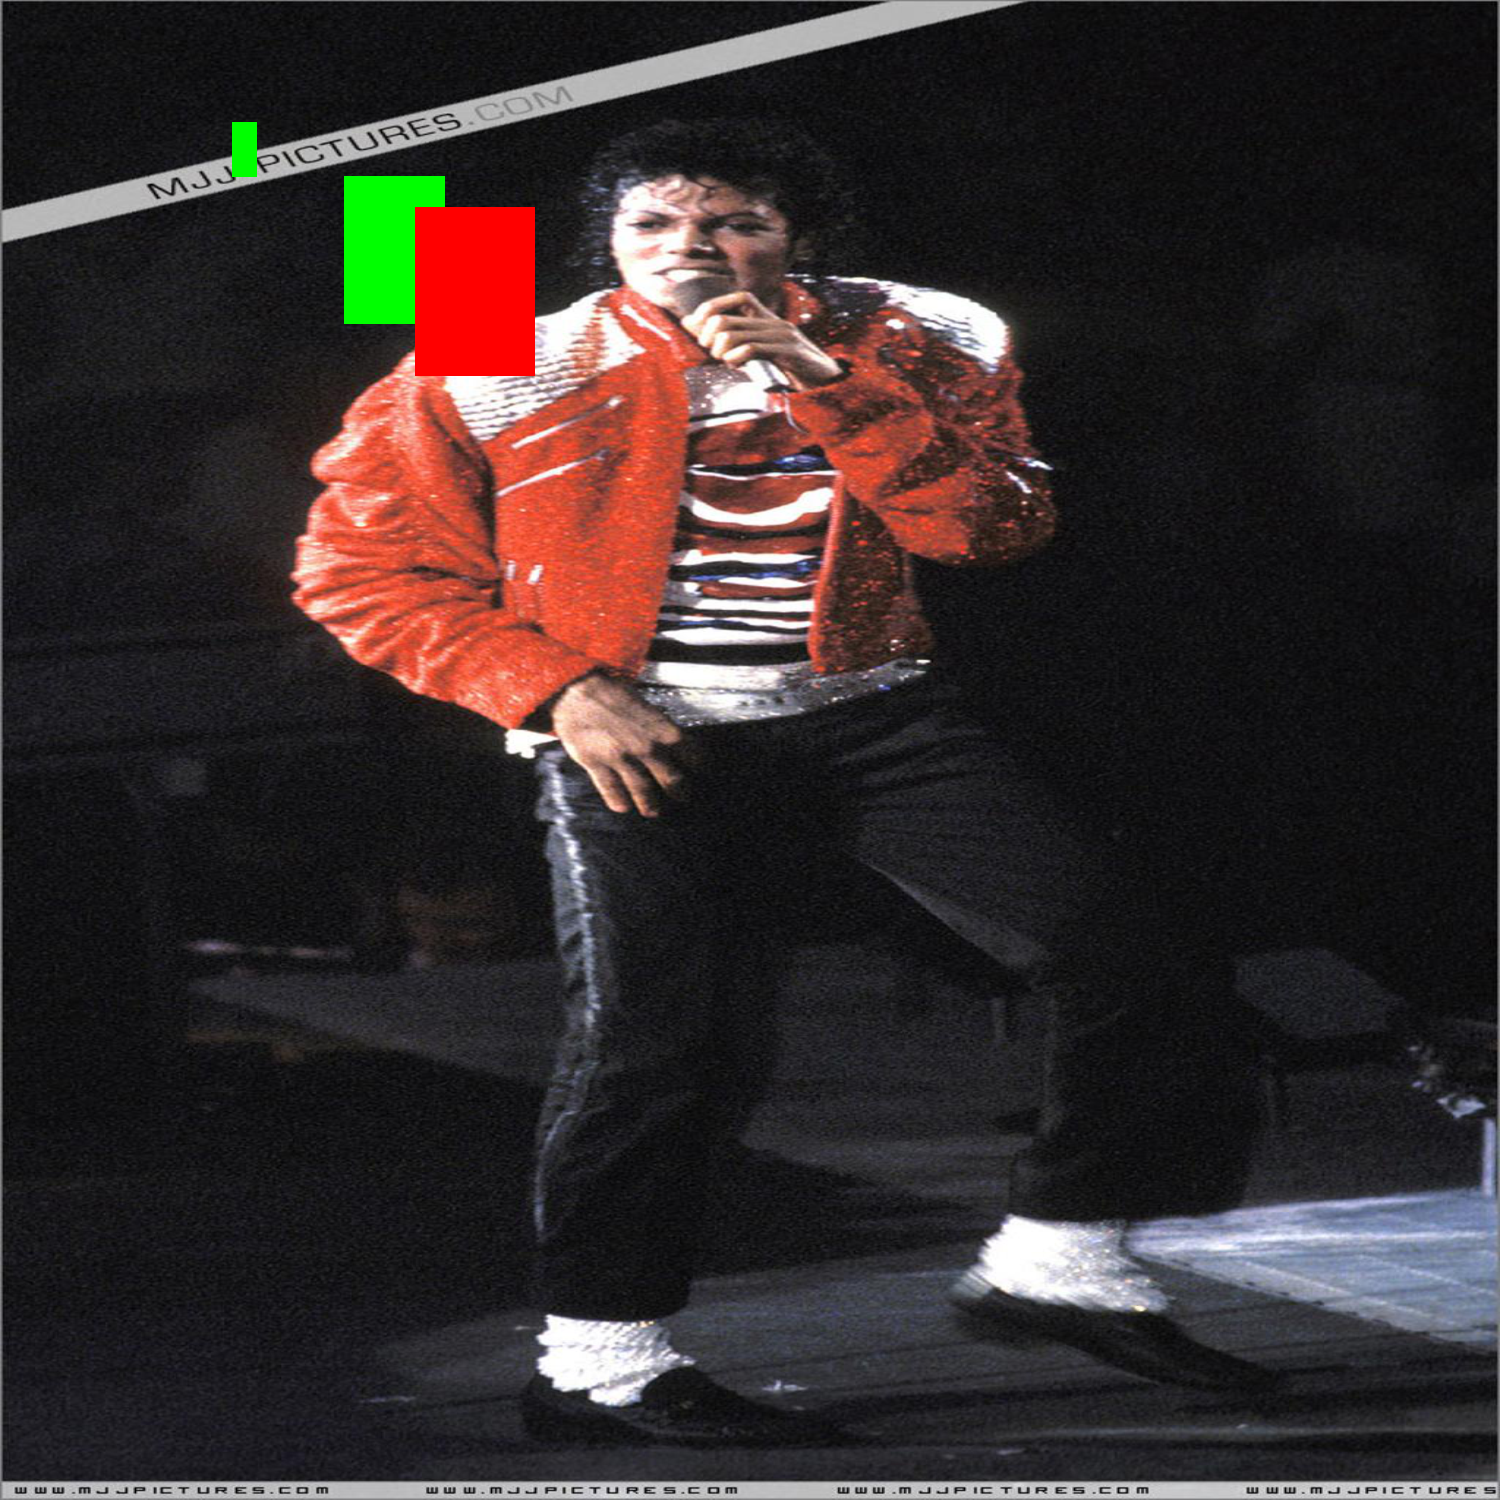

X=tensor([[[[0.5451, 0.5059, 0.4588,  ..., 0.4863, 0.4980, 0.5020],
          [0.4980, 0.4196, 0.3137,  ..., 0.3333, 0.4353, 0.5020],
          [0.4980, 0.3843, 0.2314,  ..., 0.2275, 0.3922, 0.5098],
          ...,
          [0.4863, 0.5569, 0.6510,  ..., 0.6824, 0.5804, 0.4980],
          [0.5059, 0.5490, 0.5922,  ..., 0.5843, 0.5412, 0.5059],
          [0.4902, 0.5098, 0.5255,  ..., 0.5176, 0.5098, 0.4980]],

         [[0.5451, 0.5059, 0.4588,  ..., 0.4863, 0.4980, 0.5020],
          [0.4980, 0.4196, 0.3137,  ..., 0.3333, 0.4353, 0.5020],
          [0.4980, 0.3843, 0.2314,  ..., 0.2275, 0.3922, 0.5098],
          ...,
          [0.4863, 0.5569, 0.6510,  ..., 0.6824, 0.5804, 0.4980],
          [0.5059, 0.5490, 0.5922,  ..., 0.5843, 0.5412, 0.5059],
          [0.4902, 0.5098, 0.5255,  ..., 0.5176, 0.5098, 0.4980]],

         [[0.5529, 0.5137, 0.4667,  ..., 0.4863, 0.4980, 0.5020],
          [0.5059, 0.4275, 0.3216,  ..., 0.3333, 0.4353, 0.5020],
          [0.5059, 0.3922, 0.2392,  ...,

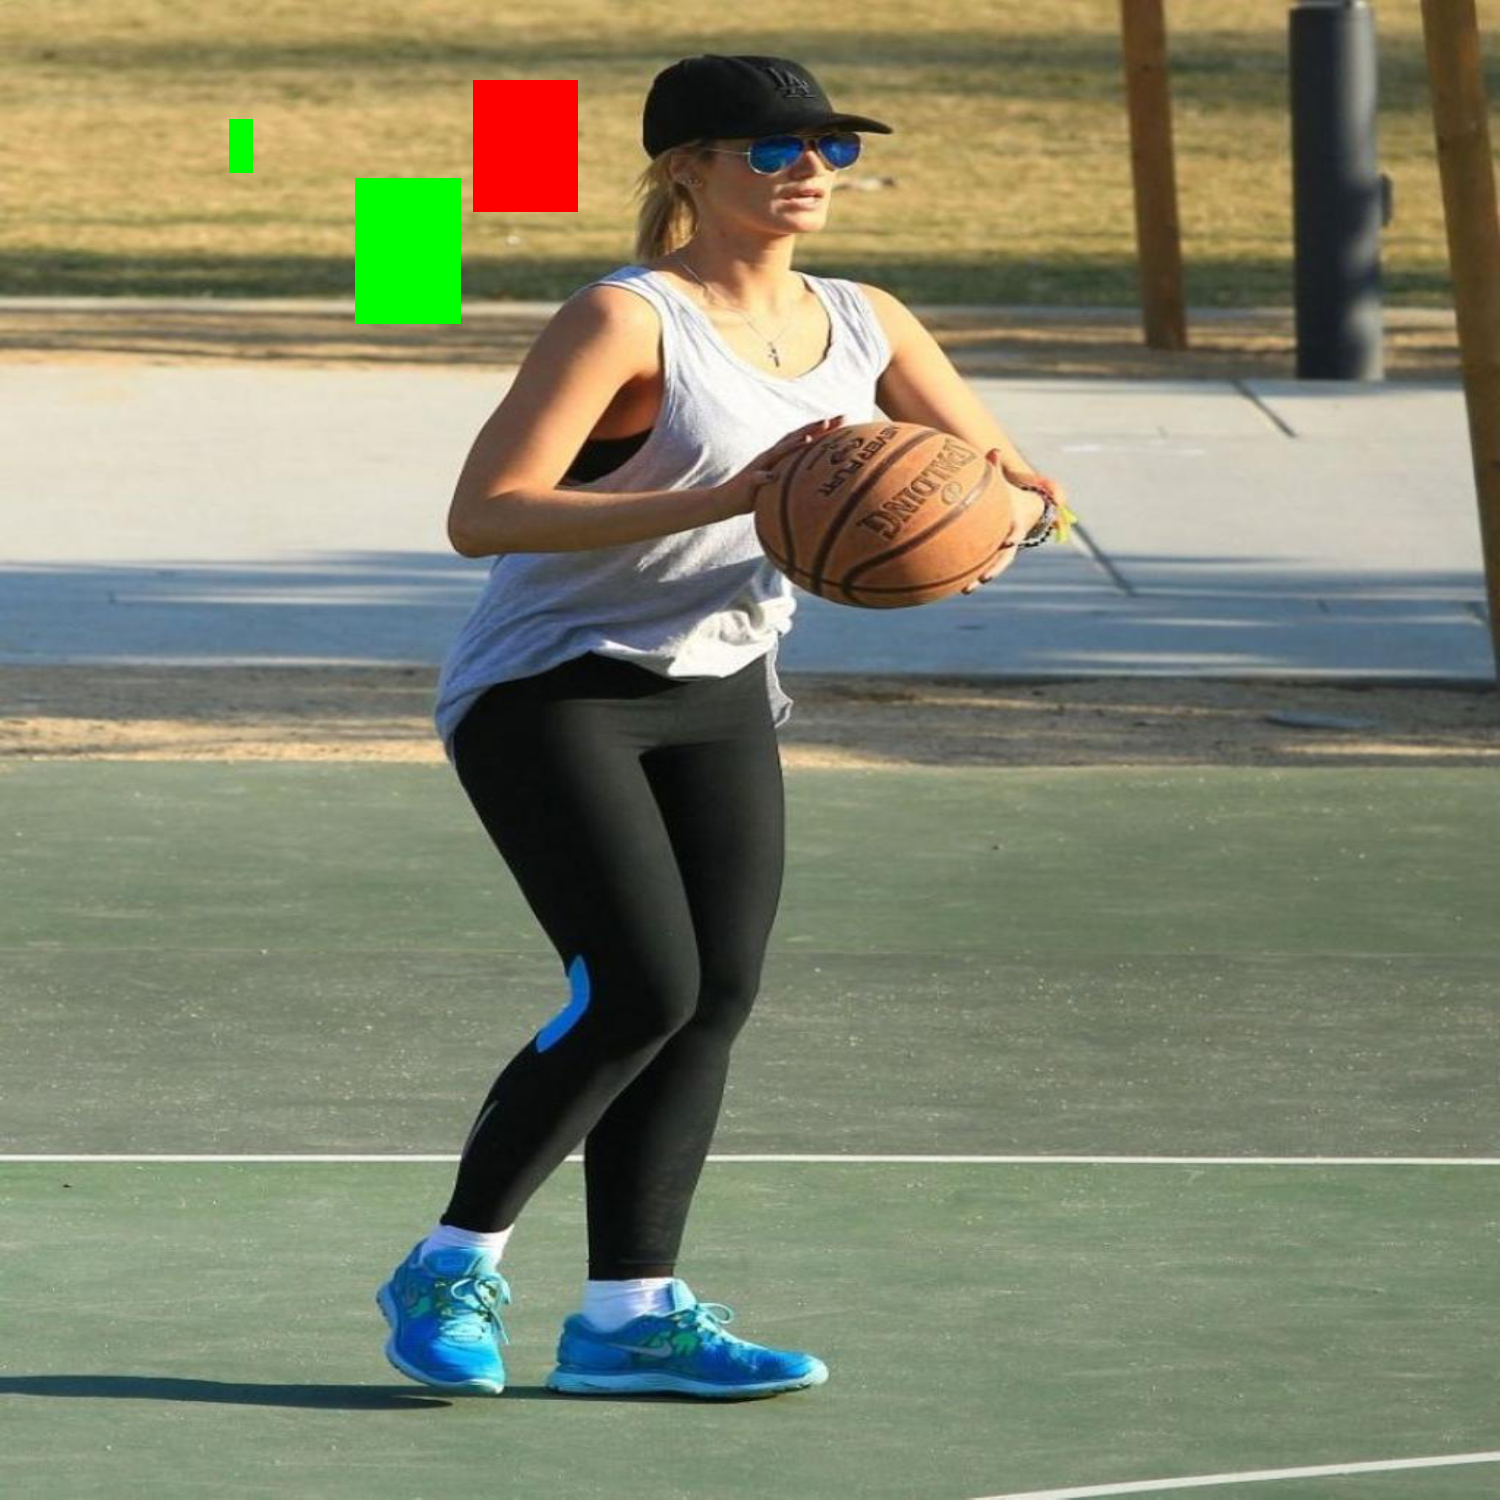

X=tensor([[[[0.5451, 0.5059, 0.4588,  ..., 0.4863, 0.4980, 0.5020],
          [0.4980, 0.4196, 0.3137,  ..., 0.3333, 0.4353, 0.5020],
          [0.4980, 0.3843, 0.2314,  ..., 0.2275, 0.3922, 0.5098],
          ...,
          [0.4863, 0.5569, 0.6510,  ..., 0.6824, 0.5804, 0.4980],
          [0.5059, 0.5490, 0.5922,  ..., 0.5843, 0.5412, 0.5059],
          [0.4902, 0.5098, 0.5255,  ..., 0.5176, 0.5098, 0.4980]],

         [[0.5451, 0.5059, 0.4588,  ..., 0.4863, 0.4980, 0.5020],
          [0.4980, 0.4196, 0.3137,  ..., 0.3333, 0.4353, 0.5020],
          [0.4980, 0.3843, 0.2314,  ..., 0.2275, 0.3922, 0.5098],
          ...,
          [0.4863, 0.5569, 0.6510,  ..., 0.6824, 0.5804, 0.4980],
          [0.5059, 0.5490, 0.5922,  ..., 0.5843, 0.5412, 0.5059],
          [0.4902, 0.5098, 0.5255,  ..., 0.5176, 0.5098, 0.4980]],

         [[0.5529, 0.5137, 0.4667,  ..., 0.4863, 0.4980, 0.5020],
          [0.5059, 0.4275, 0.3216,  ..., 0.3333, 0.4353, 0.5020],
          [0.5059, 0.3922, 0.2392,  ...,

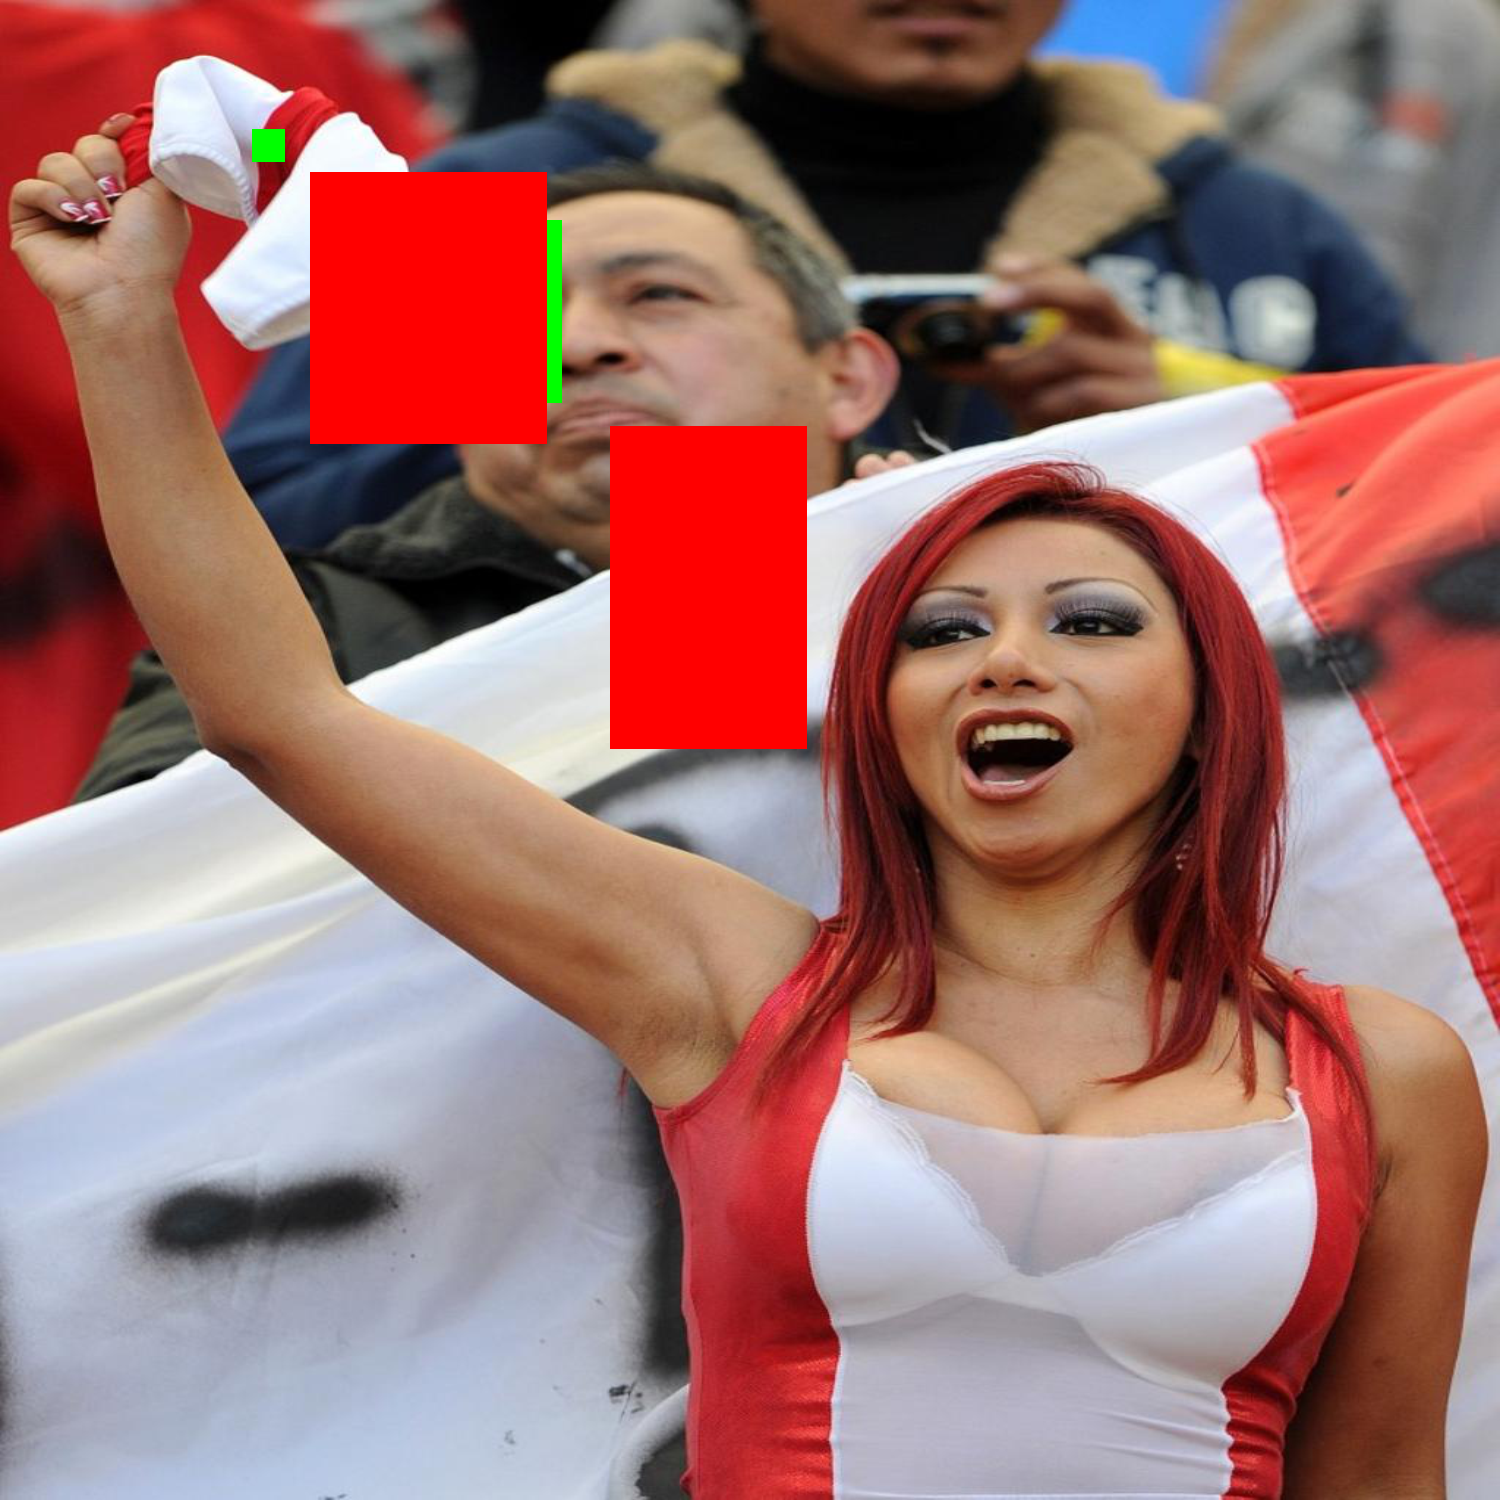

In [17]:
model.eval()
with torch.inference_mode():
    for D, _ in train_loader:
        X = D[0]
        y_pred = model(X)

        for i in range(3):
            img = tv.transforms.ToPILImage()(X[i])

            num_faces = int(y_pred[i][0] * MAX_FACES)
            data = y_pred[i] * PIXELS
            print(f"{X=}\n{data=}\t{num_faces=}\nY={D[1][i]*PIXELS})")
            for n in range(min(MAX_FACES, num_faces)):
                x = int(data[1 + n * 4])
                y = int(data[2 + n * 4])
                w = int(data[3 + n * 4])
                h = int(data[4 + n * 4])

                for x_val in range(x, x + w):
                    for y_val in range(y, y + h):
                        img.putpixel((x_val, y_val), (0, 255, 0))

            for n in range(min(MAX_FACES, int(D[1][i][0]*MAX_FACES))):
                x = int(D[1][i][1 + n * 4]*PIXELS)
                y = int(D[1][i][2 + n * 4]*PIXELS)
                w = int(D[1][i][3 + n * 4]*PIXELS)
                h = int(D[1][i][4 + n * 4]*PIXELS)

                for x_val in range(x, x + w):
                    for y_val in range(y, y + h):
                        img.putpixel((x_val, y_val), (255, 0, 0))
            display(img)
        break

### Final Results
With the MSE Loss, the loss got significantly smaller, and our output is no longer largely negative. This is a significant win. On the other hand, even when running on the same data it was trained on, it is most definitely not accurate (green boxes). On the other other hand, when trying to put on the answer key (red boxes), it still is incredibly off, so I've done something wrong.

Alas, it is the night before this is due, so I don't have time to look more into it. At least I started getting boxes in the new model, and some are vaguely in a similar location to the (incorrect) answer key.

I would call this a significant success. While there is still significantly more to do, I have a convolutional model (that doesn't run great on my computer), and my loss is at least getting very small.

Perhaps I'll come back to this, but for now, I am done.